In [1]:
# !pip install scikit-learn
# !pip install wordcloud

### Import modułów
Moduły wykorzystywane w projekcie:
* **numpy, pandas** - gromadzenie i porządkowanie danych
* **matplotlib.pyplot** - wizualizacja danych
* **sklearn (z pakietu scikit-learn)** - rozbudowane narzędzie do m.in *machine learningu*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
#from wordcloud import STOPWORDS

import time

### Zebranie danych
Za jedyne źródło danych posłużył dataset <a href="https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset" target="_blank">*The Movies Dataset*</a> ze strony *kaggle.com*. </br>
Posiada ponad 45 000 rekordów z przeróżnymi informacjami na temat filmów. W tym przypadku istotne będą jedynie kolumny z **tytułami** i **opisami**.
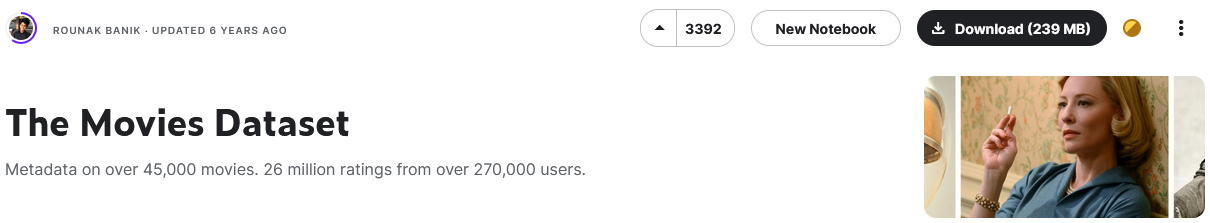

In [3]:
movies = pd.read_csv('movies_metadata.csv', low_memory=False)
print(movies.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [4]:
movies = movies[['title', 'overview', 'imdb_id', 'popularity']]
print(movies.head(3))

              title                                           overview  \
0         Toy Story  Led by Woody, Andy's toys live happily in his ...   
1           Jumanji  When siblings Judy and Peter discover an encha...   
2  Grumpier Old Men  A family wedding reignites the ancient feud be...   

     imdb_id popularity  
0  tt0114709  21.946943  
1  tt0113497  17.015539  
2  tt0113228    11.7129  


In [4]:
#print('Ilość rekordów: ', movies.shape[0])
# TODO: v xD
print(movies[movies['title'] == 'Titanic'])

         title                                           overview    imdb_id  \
1639   Titanic  84 years later, a 101-year-old woman named Ros...  tt0120338   
3285   Titanic  Unhappily married, Julia Sturges decides to go...  tt0046435   
25473  Titanic  A story of the romances of two couples upon th...  tt0115392   

      popularity  
1639    26.88907  
3285    12.90707  
25473   3.435807  


### Preprocessing danych
Przed analizą musimy oczyścić dane. Jako, że nasz Data Frame zawiera tylko dwie kolumny, nie ma wiele do zrobienia.
Usuniemy rekordy z pustymi wartościami, oraz duplikaty.

In [5]:
# Szukamy pustych rekordów i je usuwamy
missing_values = movies.isna().sum().sort_values()
print("Przed czyszczeniem:\n", missing_values)

movies.dropna(inplace=True)

missing_values_cleaned = movies.isna().sum().sort_values()
print("Po czyszczeniu:\n", missing_values_cleaned)

# Przydatne do wizualizacji
missing_data = {
    'Tytuły': (missing_values[0], missing_values_cleaned[0]),
    'imdb_id': (missing_values[1], missing_values_cleaned[1]),
    'Opisy': (missing_values[2], missing_values_cleaned[2])
}

print('Pozostało {} rekordów'.format(movies.shape[0]))

Przed czyszczeniem:
 popularity      5
title           6
imdb_id        17
overview      954
dtype: int64
Po czyszczeniu:
 title         0
overview      0
imdb_id       0
popularity    0
dtype: int64
Pozostało 44491 rekordów


In [6]:
# Szukamy duplikatów i tworzymy z nich Data Frame
duplicates_ = movies.duplicated(subset=['title', 'imdb_id'], keep=False)
duplicates = movies[duplicates_].sort_values(by='title').copy().reset_index(drop=True)
print(duplicates.head())

# Usuwanie duplikatów (zakładamy, że niemożliwym jest, że istnieją dwa filmy o takim samym tytule i imdb_id)
row_count_duplicates = movies.shape[0]

movies.drop_duplicates(subset=['title', 'imdb_id'], keep='first', inplace=True)

row_count_no_duplicates = movies.shape[0]

duplicates_prcs = row_count_no_duplicates/row_count_duplicates

print('Usunięto {} duplikatów'.format(row_count_duplicates - row_count_no_duplicates))
print('Pozostało {} rekordów'.format(movies.shape[0]))

                  title                                           overview  \
0    A Farewell to Arms  British nurse Catherine Barkley (Helen Hayes) ...   
1    A Farewell to Arms  British nurse Catherine Barkley (Helen Hayes) ...   
2  A Place at the Table  Using personal stories, this powerful document...   
3  A Place at the Table  Using personal stories, this powerful document...   
4            Black Gold  On the Arabian Peninsula in the 1930s, two war...   

     imdb_id popularity  
0  tt0022879   1.914697  
1  tt0022879   2.411191  
2  tt1736049   1.673307  
3  tt1736049   0.501046  
4  tt1701210   6.475665  
Usunięto 59 duplikatów
Pozostało 44432 rekordów


### Wizualizacja wpływu preprocessingu

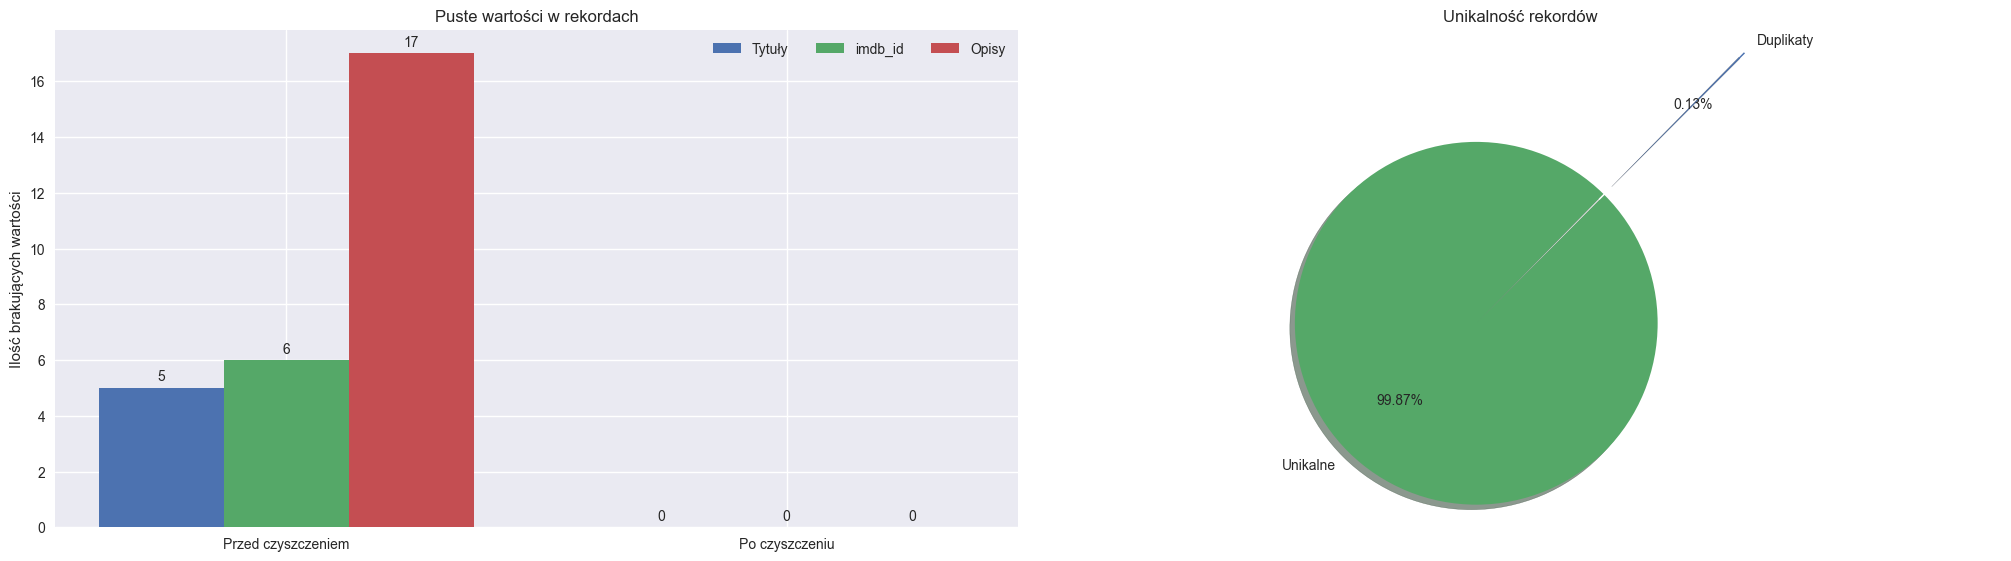

In [7]:
plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(1, 2, layout='constrained')
fig.set_figwidth(20)

# Bar chart dla czyszczenia danych
labels_bar = ('Przed czyszczeniem', 'Po czyszczeniu')
x = np.arange(len(labels_bar))
width = 0.25
multiplier = 0

for col, missing_sum in missing_data.items():
    offset = width * multiplier
    rects = ax[0].bar(x + offset, missing_sum, width, label=col)
    ax[0].bar_label(rects, padding=3)
    multiplier += 1

ax[0].set_title('Puste wartości w rekordach')
ax[0].set_ylabel('Ilość brakujących wartości')
ax[0].set_xticks(x + width, labels_bar)
ax[0].legend(loc='upper right', ncols=3)

# Pie chart dla duplikatów
labels_pie = ('Duplikaty', 'Unikalne')
sizes_pie = [1 - duplicates_prcs, duplicates_prcs]
explode =(0.1, 1)
ax[1].pie(sizes_pie, labels=labels_pie, explode=explode, shadow=True, startangle=45, autopct='%0.2f%%')
ax[1].axis('equal')
ax[1].set_title('Unikalność rekordów')

plt.show()

### Wektor Tf-idf 
**Tf-idf** Term Frequency-Inverse Document Frequency - technika używana w NLP.
Mierzy ważność słów w kontekście dokumentu w zbiorze dokumentów.

**TF (Term Frequency)**: Mierzy, jak często dany termin występuje w dokumencie. Jest to stosunek liczby wystąpień danego słowa do liczby wszystkich słów w dokumencie. </br>
$$ 
\begin{align}
\frac{\text{Wystapienie słowa}}{\text{Liczba słów w dokumencie}}
\end{align}
$$

**IDF (Inverse Document Frequency)**: Określa, jak istotne jest dane słowo w kontekście całego zbioru dokumentów. Wartość IDF rośnie, gdy słowo występuje rzadko we wszystkich dokumentach w zbiorze. </br>
$$ 
\begin{align}
\log(\frac{\text{W ilu dokumentach wystąpiło słowo}}{\text{Liczba dokumentów}})
\end{align}
$$


In [8]:
# TODO: dostroić parametry
tfidf_vect = TfidfVectorizer(stop_words='english', max_df = 0.7)
tfidf_matrix = tfidf_vect.fit_transform(movies['overview'].values)

### Podobieństwo cosiunowe (Cosine similarity)
Podobieństwo cosinusowe (cosine similarity) to miara używana w analizie tekstu do oceny stopnia podobieństwa między dwoma wektorami reprezentującymi teksty.
Mierzy kąt między tymi wektorami w wielowymiarowej przestrzeni, przy czym niższy kąt oznacza większe podobieństwo. </br>
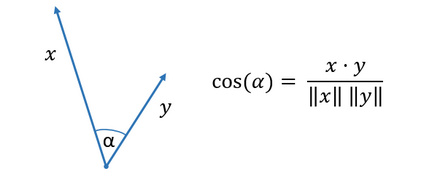

In [9]:
# Macierz stworzona przy użyciu 'cosine similarity'
cosine_sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
print('Ilość wierszy: {}\nIlość kolumn: {}'.format(*cosine_sim_matrix.shape))

# Macierz przedstawia kombinację podobieństwa wszystkich filmów (opisów)
movies_cosine = pd.DataFrame(cosine_sim_matrix, index=movies['title'].values, columns=movies['title'].values)
print(movies_cosine.head())

Ilość wierszy: 44432
Ilość kolumn: 44432
                             Toy Story   Jumanji  Grumpier Old Men  \
Toy Story                     1.000000  0.015013          0.000000   
Jumanji                       0.015013  1.000000          0.046808   
Grumpier Old Men              0.000000  0.046808          1.000000   
Waiting to Exhale             0.000000  0.000000          0.000000   
Father of the Bride Part II   0.000000  0.000000          0.025058   

                             Waiting to Exhale  Father of the Bride Part II  \
Toy Story                                  0.0                     0.000000   
Jumanji                                    0.0                     0.000000   
Grumpier Old Men                           0.0                     0.025058   
Waiting to Exhale                          1.0                     0.000000   
Father of the Bride Part II                0.0                     1.000000   

                                 Heat   Sabrina  Tom and Huck  

### Funkcje do wyszukiwania/wyświetlania wyników

In [10]:
# Funkcja wyszukująca
def find_similar_to(title=''):
    similiarities = movies_cosine.loc[title]
    # TODO: JEŻELI WIĘCEJ WYNIKÓW TO ZNAJDZ NAJPOPULARNIEJSZY 
    print(similiarities)
    # Ucinamy pierwszy element - zawiera ten sam film
    top_similiarities = similiarities.sort_values(ascending=False)

    # Zwracamy top 10 wyników
    return dict(top_similiarities[1:11].items())

In [1]:
def create_chart_for_matches(matches={}, title="", savetofile=False):
    plt.style.use('seaborn-v0_8')
    fig, ax = plt.subplots()

    for movie, similarity in matches.items():
        rects = ax.bar(np.round(similarity*100, 2), movie)
        ax.bar_label(rects, padding=2)

    plt.ylim(0, 100)
    ax.set_title('Najlepsze dopasowania dla filmu {}'.format(title))
    ax.set_xlabel('Znalezione filmy')
    ax.set_ylabel('Zgodność opisów (%)')

    plt.show()

    if savetofile:
        fig.savefig('{}_matches.jpg'.format(title.replace(' ', '_')))

### Rezultat

In [2]:
movie_title = 'Back to the Future'
top_matches = find_similar_to(title=movie_title)
create_chart_for_matches(matches=top_matches, title=movie_title, savetofile=False)

NameError: name 'find_similar_to' is not defined